In [2]:
import os
import pandas as pd

# Folder containing your CSV files
folder_path = "/kaggle/input/dataset-gait"  # 🔁 Replace this with your actual folder name

# Initialize list to hold DataFrames
all_dfs = []

# Loop through all files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith(".csv"):
        file_path = os.path.join(folder_path, filename)
        df = pd.read_csv(file_path)
        df['TestID'] = filename  # Optional: tag with filename or test ID
        all_dfs.append(df)

# Combine all into a single DataFrame
full_df = pd.concat(all_dfs, ignore_index=True)
print(f"✅ Loaded {len(all_dfs)} files, total rows: {len(full_df)}")

✅ Loaded 10 files, total rows: 61703


In [3]:
import pandas as pd
import numpy as np
from pprint import pprint


# all_dfs = []
# for i in range(1, 11):
#     filename = f"labeled_gait_output_{i}.csv"
#     if os.path.exists(filename):
#         df = pd.read_csv(filename)
#         df['TestID'] = i  # optional: add a column to identify which test
#         all_dfs.append(df)
#     else:
#         print(f"⚠️ Missing file: {filename}")

# Combine all into one DataFrame
df = full_df


# Load the labeled dataset
# df = pd.read_csv("labeled_gait_output.csv")

# Initialize dictionary to store features
features = {}

# ---------------
# Time Features
# ---------------
features["duration_sec"] = (df["Time"].iloc[-1] - df["Time"].iloc[0]) / 1000.0

# ---------------
# Force Features
# ---------------
for side in ["Left", "Right"]:
    force_col = f"{side}_Force"
    features[f"{side}_force_mean"] = df[force_col].mean()
    features[f"{side}_force_std"] = df[force_col].std()
    features[f"{side}_force_range"] = df[force_col].max() - df[force_col].min()

# ---------------
# Joint Angle Features
# ---------------
for side in ["Left", "Right"]:
    angle_col = f"{side}_Ankle_Angle"
    features[f"{side}_angle_mean"] = df[angle_col].mean()
    features[f"{side}_angle_std"] = df[angle_col].std()
    features[f"{side}_angle_range"] = df[angle_col].max() - df[angle_col].min()
    features[f"{side}_angle_max"] = df[angle_col].max()
    features[f"{side}_angle_min"] = df[angle_col].min()

# ---------------
# Gait Phase Duration Features
# ---------------
for side in ["Left", "Right"]:
    phase_col = f"{side}_Gait_Phase"
    total_frames = len(df)
    phase_counts = df[phase_col].value_counts(normalize=True)  # % of time
    for phase in ["Stance", "Swing", "Heel Strike", "Toe-Off"]:
        features[f"{side}_phase_pct_{phase.replace(' ', '_')}"] = phase_counts.get(phase, 0.0) * 100

# ---------------
# Symmetry Features
# ---------------
def symmetry_index(val_left, val_right):
    return abs(val_left - val_right) / max((val_left + val_right) / 2, 1e-6) * 100

features["angle_symmetry_index"] = symmetry_index(
    features["Left_angle_mean"], features["Right_angle_mean"]
)
features["force_symmetry_index"] = symmetry_index(
    features["Left_force_mean"], features["Right_force_mean"]
)
features["stance_symmetry_index"] = symmetry_index(
    features["Left_phase_pct_Stance"], features["Right_phase_pct_Stance"]
)

# ---------------
# Print Final Feature Set
# ---------------
print("✅ Gait ML Features:")
pprint(features)


✅ Gait ML Features:
{'Left_angle_max': 4.220077767564014,
 'Left_angle_mean': -0.21636805891236036,
 'Left_angle_min': -6.493107399719546,
 'Left_angle_range': 10.713185167283559,
 'Left_angle_std': 1.8111423985686537,
 'Left_force_mean': 848.4450604978681,
 'Left_force_range': 3317.699715573002,
 'Left_force_std': 970.99245653616,
 'Left_phase_pct_Heel_Strike': 0.2641686789945384,
 'Left_phase_pct_Stance': 39.30765116769039,
 'Left_phase_pct_Swing': 60.16725280780513,
 'Left_phase_pct_Toe-Off': 0.2609273455099428,
 'Right_angle_max': 21.457046550116804,
 'Right_angle_mean': -0.5347642600098753,
 'Right_angle_min': -34.98024205985016,
 'Right_angle_range': 56.43728860996697,
 'Right_angle_std': 10.13061017362591,
 'Right_force_mean': 829.6827883679148,
 'Right_force_range': 3183.6901182473634,
 'Right_force_std': 911.3562128789434,
 'Right_phase_pct_Heel_Strike': 0.2657893457368361,
 'Right_phase_pct_Stance': 38.32876845534253,
 'Right_phase_pct_Swing': 61.15099752037988,
 'Right_phase

heel strike 0
stance 1
Swing 2
toe-off 3

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

In [5]:
# -------------------------------
# 1. Load Data
# -------------------------------
df = full_df

# Features from both sides for full-body context
features = [
    "LT_GyroX_filtered", "LT_GyroY_filtered", "LT_GyroZ_filtered",
    "LS_GyroX_filtered", "LS_GyroY_filtered", "LS_GyroZ_filtered",
    "LA_GyroX_filtered", "LA_GyroY_filtered", "LA_GyroZ_filtered",
    "Left_Ankle_Angle", "Left_Force",
    "RT_GyroX_filtered", "RT_GyroY_filtered", "RT_GyroZ_filtered",
    "RS_GyroX_filtered", "RS_GyroY_filtered", "RS_GyroZ_filtered",
    "RA_GyroX_filtered", "RA_GyroY_filtered", "RA_GyroZ_filtered",
    "Right_Ankle_Angle", "Right_Force"
]

X = df[features]
y_raw = df["Left_Gait_Phase"]

In [6]:

# -------------------------------
# 2. Encode Labels
# -------------------------------
le = LabelEncoder()
y = le.fit_transform(y_raw)
class_names = le.classes_

In [7]:
print(df["Left_Gait_Phase"].value_counts())

Left_Gait_Phase
Swing          37125
Stance         24254
Heel Strike      163
Toe-Off          161
Name: count, dtype: int64


In [8]:
# # -------------------------------
# # 4. Define Classifiers
# # -------------------------------
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier  # Requires `pip install xgboost`

models = {
    "Random Forest": RandomForestClassifier(class_weight='balanced'),
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced'),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Support Vector Machine (SVM)": SVC(class_weight='balanced'),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Decision Tree": DecisionTreeClassifier(class_weight='balanced'),
    "Naive Bayes": GaussianNB(),
    "AdaBoost": AdaBoostClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
}


In [9]:
# # -------------------------------
# # 5. Train & Evaluate
# # -------------------------------
# for name, model in models.items():
#     print(f"\n🔍 Training: {name}")
#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)

#     acc = accuracy_score(y_test, y_pred)
#     print(f"✅ Accuracy: {acc:.4f}")
#     report = classification_report(y_test, y_pred, output_dict=True)
#     print(classification_report(y_test, y_pred, target_names=class_names, digits=4))
#     for cls in class_names:
#         print(f"F1 Score - {cls}: {report[cls]['f1-score']:.4f}")
#     print(f"Macro F1: {report['macro avg']['f1-score']:.4f}")

#     # Confusion matrix
#     cm = confusion_matrix(y_test, y_pred)
#     plt.figure(figsize=(6, 4))
#     sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap="Blues")
#     plt.title(f"{name} - Confusion Matrix")
#     plt.xlabel("Predicted")
#     plt.ylabel("True")
#     plt.tight_layout()
#     plt.show()

In [10]:
!pip install -q scikit-learn==1.2.2 imbalanced-learn==0.10.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 5.3 MB/s eta 0:00:0000:01


In [11]:
import os
os.environ["OMP_NUM_THREADS"] = "1"

In [12]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Encode labels
le = LabelEncoder()
full_df["EncodedLabel"] = le.fit_transform(full_df["Left_Gait_Phase"])
class_names = le.classes_

# Split
X = full_df[features]
y = full_df["EncodedLabel"]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Balance training data
sm = SMOTE(random_state=42)
X_train_bal, y_train_bal = sm.fit_resample(X_train, y_train)


In [13]:
# Summary dictionaries
results_df = pd.DataFrame(columns=["Model", "Accuracy", "Macro F1", "Weighted F1"])
conf_matrices = {}
per_class_f1 = pd.DataFrame(columns=["Model", "Class", "F1-Score"])



🔍 Training: Random Forest

📊 Results for Random Forest
✅ Accuracy     : 0.9969
✅ Macro F1     : 0.8644
✅ Weighted F1  : 0.9970

🔹 Per-Class F1 Scores:
Heel Strike    : 0.0000
Stance         : 0.0000
Swing          : 0.0000
Toe-Off        : 0.0000


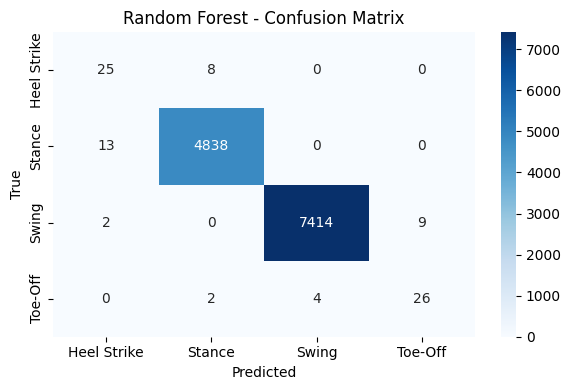


🔍 Training: Logistic Regression


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



📊 Results for Logistic Regression
✅ Accuracy     : 0.8434
✅ Macro F1     : 0.4892
✅ Weighted F1  : 0.8974

🔹 Per-Class F1 Scores:
Heel Strike    : 0.0000
Stance         : 0.0000
Swing          : 0.0000
Toe-Off        : 0.0000


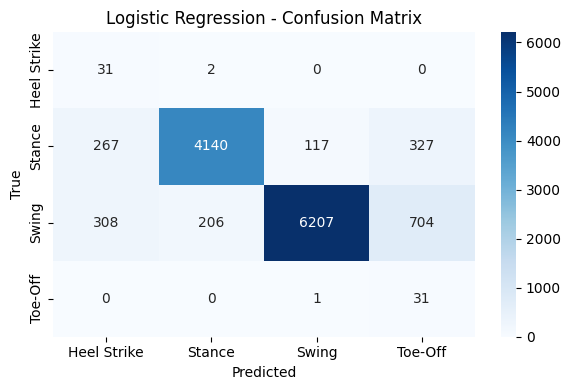


🔍 Training: K-Nearest Neighbors

📊 Results for K-Nearest Neighbors
✅ Accuracy     : 0.9870
✅ Macro F1     : 0.6904
✅ Weighted F1  : 0.9901

🔹 Per-Class F1 Scores:
Heel Strike    : 0.0000
Stance         : 0.0000
Swing          : 0.0000
Toe-Off        : 0.0000


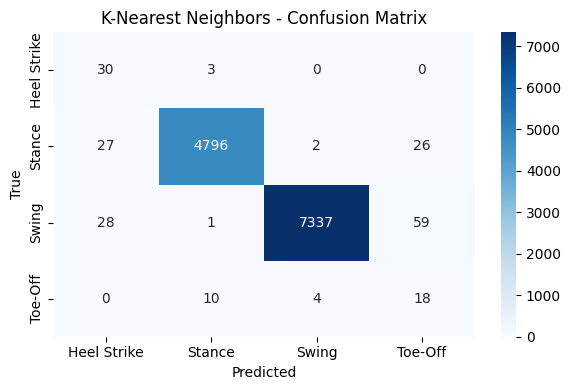


🔍 Training: Support Vector Machine (SVM)

📊 Results for Support Vector Machine (SVM)
✅ Accuracy     : 0.9558
✅ Macro F1     : 0.6207
✅ Weighted F1  : 0.9680

🔹 Per-Class F1 Scores:
Heel Strike    : 0.0000
Stance         : 0.0000
Swing          : 0.0000
Toe-Off        : 0.0000


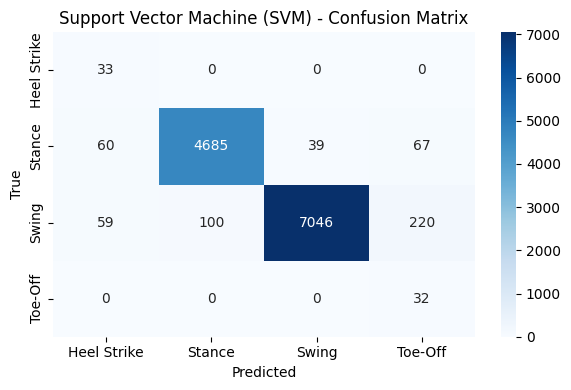


🔍 Training: Gradient Boosting

📊 Results for Gradient Boosting
✅ Accuracy     : 0.9956
✅ Macro F1     : 0.8727
✅ Weighted F1  : 0.9960

🔹 Per-Class F1 Scores:
Heel Strike    : 0.0000
Stance         : 0.0000
Swing          : 0.0000
Toe-Off        : 0.0000


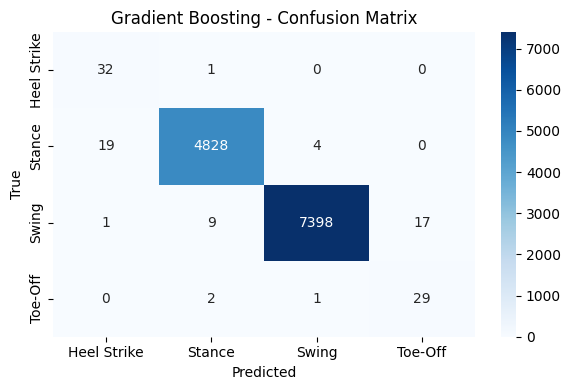


🔍 Training: Decision Tree

📊 Results for Decision Tree
✅ Accuracy     : 0.9963
✅ Macro F1     : 0.8487
✅ Weighted F1  : 0.9964

🔹 Per-Class F1 Scores:
Heel Strike    : 0.0000
Stance         : 0.0000
Swing          : 0.0000
Toe-Off        : 0.0000


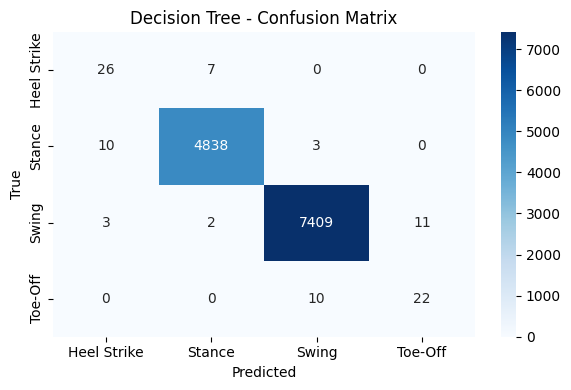


🔍 Training: Naive Bayes

📊 Results for Naive Bayes
✅ Accuracy     : 0.9037
✅ Macro F1     : 0.5948
✅ Weighted F1  : 0.9201

🔹 Per-Class F1 Scores:
Heel Strike    : 0.0000
Stance         : 0.0000
Swing          : 0.0000
Toe-Off        : 0.0000


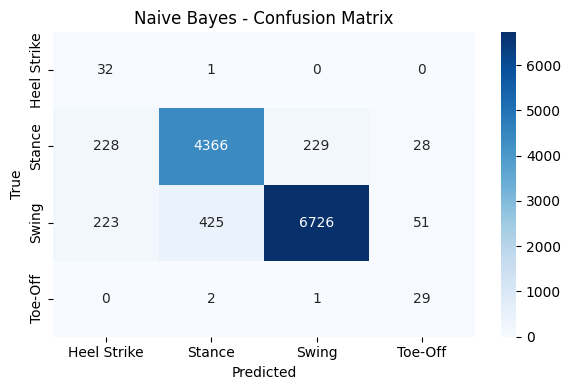


🔍 Training: AdaBoost

📊 Results for AdaBoost
✅ Accuracy     : 0.7132
✅ Macro F1     : 0.4314
✅ Weighted F1  : 0.8194

🔹 Per-Class F1 Scores:
Heel Strike    : 0.0000
Stance         : 0.0000
Swing          : 0.0000
Toe-Off        : 0.0000


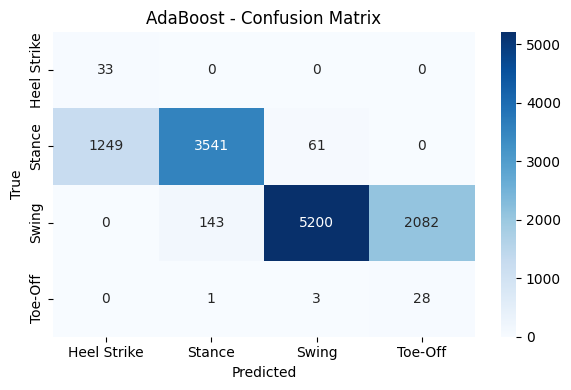


🔍 Training: XGBoost

📊 Results for XGBoost
✅ Accuracy     : 0.9971
✅ Macro F1     : 0.8688
✅ Weighted F1  : 0.9972

🔹 Per-Class F1 Scores:
Heel Strike    : 0.0000
Stance         : 0.0000
Swing          : 0.0000
Toe-Off        : 0.0000


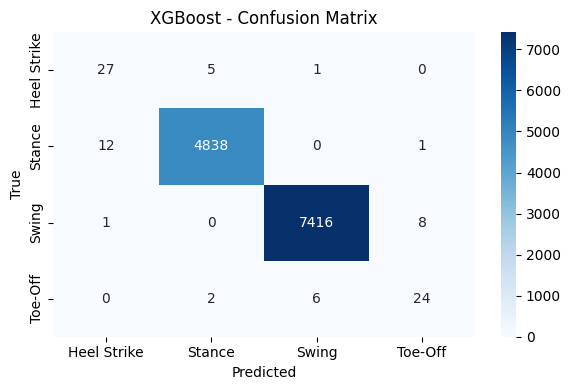

In [14]:
for model_name, model in models.items():
    print(f"\n🔍 Training: {model_name}")
    model.fit(X_train_bal, y_train_bal)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    macro_f1 = report["macro avg"]["f1-score"]
    weighted_f1 = report["weighted avg"]["f1-score"]

    # Print main metrics
    print(f"\n📊 Results for {model_name}")
    print(f"✅ Accuracy     : {acc:.4f}")
    print(f"✅ Macro F1     : {macro_f1:.4f}")
    print(f"✅ Weighted F1  : {weighted_f1:.4f}")

    # Print per-class F1 scores
    print("\n🔹 Per-Class F1 Scores:")
    for cls in class_names:
        f1 = report.get(cls, {}).get("f1-score", 0.0)
        print(f"{cls:15}: {f1:.4f}")

    # Log summary metrics
    results_df.loc[len(results_df)] = [model_name, acc, macro_f1, weighted_f1]

    # Store confusion matrix
    conf_matrices[model_name] = confusion_matrix(y_test, y_pred, labels=np.arange(len(class_names)))

    # Store per-class F1
    for cls in class_names:
        f1 = report.get(cls, {}).get("f1-score", 0.0)
        per_class_f1.loc[len(per_class_f1)] = [model_name, cls, f1]

    # Plot confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrices[model_name], annot=True, fmt='d',
                xticklabels=class_names, yticklabels=class_names, cmap="Blues")
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()


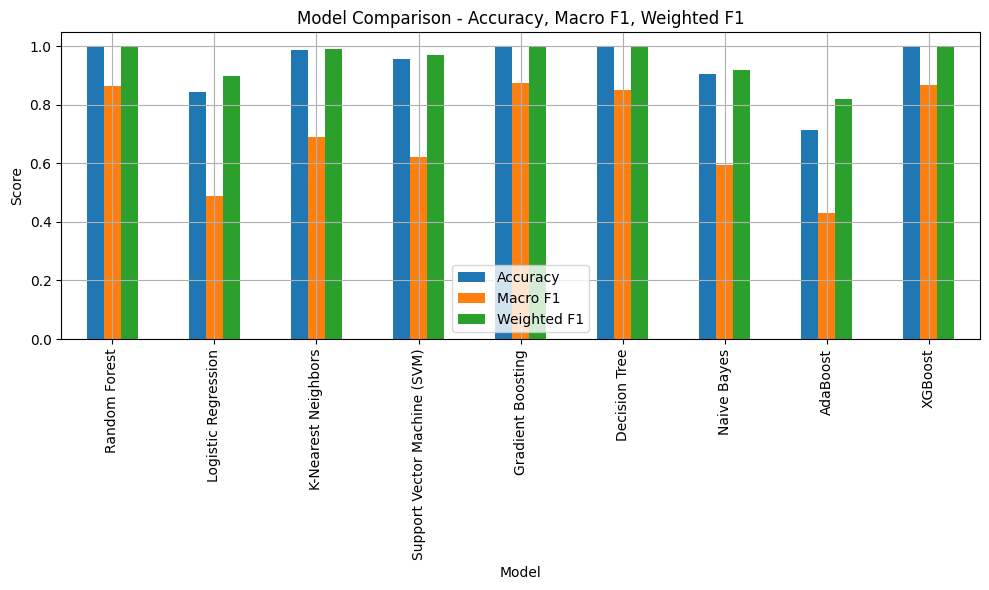

In [21]:
results_df.set_index("Model")[["Accuracy", "Macro F1", "Weighted F1"]].plot(kind="bar", figsize=(10, 6))
plt.title("Model Comparison - Accuracy, Macro F1, Weighted F1")
plt.ylabel("Score")
plt.grid(True)
plt.tight_layout()
plt.show()


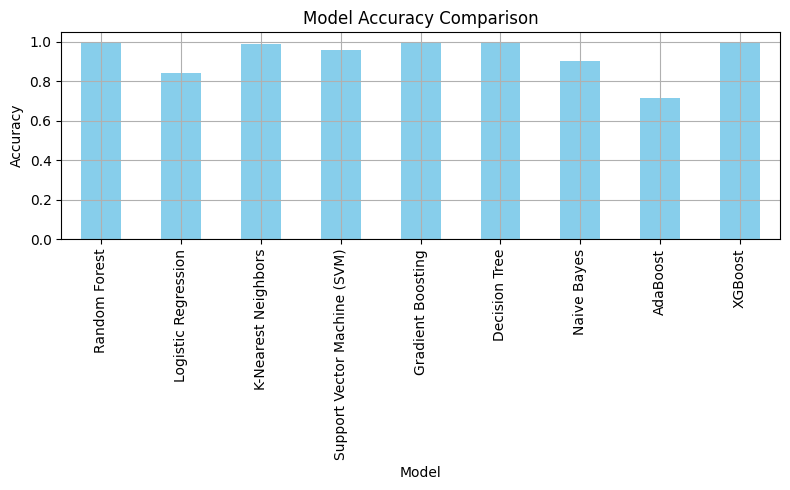

In [22]:
results_df.set_index("Model")[["Accuracy"]].plot(kind="bar", color="skyblue", legend=False, figsize=(8, 5))
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Reformat dataframe for plotting
plot_df = results_df.set_index("Model")[["Accuracy", "Macro F1", "Weighted F1"]]

# Create grouped bar plot with annotations
ax = plot_df.plot(kind='bar', figsize=(12, 6), rot=45)
plt.title("Model Comparison: Accuracy, Macro F1, Weighted F1")
plt.ylabel("Score")
plt.ylim(plot_df.min().min() - 0.05, 1.0)
plt.grid(axis='y')

# Annotate each bar with its value
for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', label_type='edge', padding=3)

plt.tight_layout()
plt.show()


In [ ]:
import seaborn as sns

plt.figure(figsize=(14, 6))
sns.barplot(data=per_class_f1, x="Class", y="F1-Score", hue="Model")
plt.title("Per-Class F1 Score Comparison Across Models")
plt.ylabel("F1 Score")
plt.ylim(0, 1.0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [ ]:
plt.figure(figsize=(10, 5))
sns.heatmap(results_df.set_index("Model"), annot=True, fmt=".3f", cmap="Blues")
plt.title("Heatmap: Accuracy, Macro F1, Weighted F1 for Each Model")
plt.tight_layout()
plt.show()
